# Graph-Sparse Logistic Regression applied to the real proteomics data from Tobi's Medulloblastoma dataset. 

In [1]:
%pylab inline

import sys
import pickle
import pandas as pd
import networkx as nx

from sklearn.preprocessing import LabelEncoder

from matplotlib_venn import venn3, venn3_circles, venn2

repo_path = '/Users/alex/Documents/gslr/'
interactome_path = repo_path + 'experiments/algorithms/pcsf/inbiomap_temp.tsv'

sys.path.append(repo_path + 'gslr/')
import gslr

Populating the interactive namespace from numpy and matplotlib


### i. Load Datasets

In [2]:
medullo = pd.read_csv('/Users/alex/Documents/proteomics/data_preparation/proteomics_data/medullo_inbiomap_exp.tsv', index_col=0)
# ovarian = pd.read_csv('/Users/alex/Documents/proteomics/data_preparation/proteomics_data/ovarian_inbiomap_exp.tsv', index_col=0)
# brca = pd.read_csv('/Users/alex/Documents/proteomics/data_preparation/proteomics_data/brca_inbiomap_exp.tsv', index_col=0)

medullo_labels = pd.read_csv('/Users/alex/Documents/proteomics/data_preparation/proteomics_data/raw/medullo_labels.csv', index_col=0)
# ovarian_labels = pd.read_csv('/Users/alex/Documents/proteomics/data_preparation/proteomics_data/raw/ovarian_labels.csv', index_col=0)
# brca_labels = pd.read_csv('/Users/alex/Documents/proteomics/data_preparation/proteomics_data/raw/brca_labels.csv', index_col=0)

### ii. Load Interactome

In [3]:
inbiomap_experimentally = pd.read_csv(interactome_path, sep='\t', names=['protein1','protein2','cost'])
inbiomap_experimentally.head()

,protein1,protein2,cost
0,ZNF91,NDEL1,1.253
1,ZNF91,ELAVL1,1.254
2,ZNF91,SUMO1,1.245
3,ZNF91,SUMO3,1.245
4,ZNF91,CHMP5,1.241


In [4]:
(edges, nodes) = pd.factorize(inbiomap_experimentally[["protein1","protein2"]].unstack())
edges = edges.reshape(inbiomap_experimentally[["protein1","protein2"]].shape, order='F')
edges

array([[    0,  1228],
       [    0,  1279],
       [    0,  4071],
       ..., 
       [14190, 14237],
       [14191, 14378],
       [14192, 14539]])

In [5]:
dataset = medullo.copy()
labels = medullo_labels.loc['SUB GRP']
dataset.shape, labels.shape

((45, 16349), (45,))

### i. Prepare Dataset

In [6]:
dataset = dataset.transpose().reindex(index=nodes).transpose()
X = dataset.values
dataset.head()

,ZNF91,ACP5,SLC27A2,PAX9,ADAM15,ELOVL2,DDX60L,FGF7,CDHR5,LYPD3,...,CNR2,GIG44,LINC00588,TAAR2,CHRNE,ANKAR,DHH,CYSLTR1,COL23A1,MEDAG
MB278,0.602763,0.583258,-4.491493,0.0,0.983126,0.053351,-3.093579,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MB282,1.785166,0.829080,-2.564315,0.0,-0.523712,1.045983,-2.829736,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MB275,-0.482891,0.534735,-3.399802,0.0,-0.427655,-2.694475,0.558104,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MB247,0.422619,0.841987,-0.535474,0.0,-0.096751,-2.374239,-1.193558,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MB091,-0.394541,-0.222525,1.049852,0.0,0.064170,0.809575,-1.262815,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
labels = labels.values.flatten().tolist()

In [11]:
labeler = LabelEncoder()
labeler.fit(labels)
y = labeler.transform(labels)
y

array([0, 1, 2, 0, 1, 2, 1, 2, 1, 3, 0, 1, 0, 2, 2, 0, 1, 2, 1, 0, 2, 0, 2,
       1, 2, 0, 1, 1, 2, 1, 2, 1, 0, 0, 3, 2, 1, 2, 2, 0, 3, 0, 1, 0, 2])

### ii. Graph-Sparse Logistic Regression

In [17]:
d = len(nodes)
c = 4

graph_opts = gslr.GraphOptions(edges=edges, root=-1, num_clusters=1, pruning='strong')

sparsity_low = 150
sparsity_high = 400

verbosity_level = 1

num_steps = 100
possible_steps = np.array([0.03, 0.1, 0.3])
steps = np.tile(possible_steps, (num_steps, 1))

W0 = np.zeros((c, d))

In [14]:
W_hat, losses = gslr.gslr(X, y, W0, sparsity_low, sparsity_high, graph_opts, steps, verbosity_level, edge_costs=inbiomap_experimentally.cost.values, edge_costs_multiplier=2)

iteration 1:
  loss_cur = 1.386294361119889   loss_next = 0.2270185953679324   step_size = 0.03
  loss_cur = 1.386294361119889   loss_next = 0.5948564674914786   step_size = 0.1
  loss_cur = 1.386294361119889   loss_next = 1.8469201690431871   step_size = 0.3
  best_step_size: 0.03
iteration 2:
  loss_cur = 0.2270185953679324   loss_next = 0.061819564463270596   step_size = 0.03
  loss_cur = 0.2270185953679324   loss_next = 2.123099720836737   step_size = 0.1
  loss_cur = 0.2270185953679324   loss_next = 12.923132949830963   step_size = 0.3
  best_step_size: 0.03
iteration 3:
  loss_cur = 0.061819564463270596   loss_next = 0.034507172179402634   step_size = 0.03
  loss_cur = 0.061819564463270596   loss_next = 0.12274499798764443   step_size = 0.1
  loss_cur = 0.061819564463270596   loss_next = 2.4936697386911066   step_size = 0.3
  best_step_size: 0.03
iteration 4:
  loss_cur = 0.034507172179402634   loss_next = 0.02238666131855774   step_size = 0.03
  loss_cur = 0.034507172179402634  

  loss_cur = 0.0007743985246896298   loss_next = 0.0007472137154536519   step_size = 0.3
  best_step_size: 0.3
iteration 29:
  loss_cur = 0.0007472137154536519   loss_next = 0.0007446854183785859   step_size = 0.03
  loss_cur = 0.0007472137154536519   loss_next = 0.0007388274577305087   step_size = 0.1
  loss_cur = 0.0007472137154536519   loss_next = 0.0007224048873906882   step_size = 0.3
  best_step_size: 0.3
iteration 30:
  loss_cur = 0.0007224048873906882   loss_next = 0.000720077620319736   step_size = 0.03
  loss_cur = 0.0007224048873906882   loss_next = 0.0007146816139965495   step_size = 0.1
  loss_cur = 0.0007224048873906882   loss_next = 0.0006995253002308737   step_size = 0.3
  best_step_size: 0.3
iteration 31:
  loss_cur = 0.0006995253002308737   loss_next = 0.000697121231696715   step_size = 0.03
  loss_cur = 0.0006995253002308737   loss_next = 0.0006921135704457508   step_size = 0.1
  loss_cur = 0.0006995253002308737   loss_next = 0.0006726984319669877   step_size = 0.3
 

  loss_cur = 0.00047562520296809505   loss_next = 0.000466071827310785   step_size = 0.3
  best_step_size: 0.3
iteration 47:
  loss_cur = 0.000466071827310785   loss_next = 0.00046514657469530235   step_size = 0.03
  loss_cur = 0.000466071827310785   loss_next = 0.0004629949110922747   step_size = 0.1
  loss_cur = 0.000466071827310785   loss_next = 0.0004569029204377245   step_size = 0.3
  best_step_size: 0.3
iteration 48:
  loss_cur = 0.0004569029204377245   loss_next = 0.0004560142992302888   step_size = 0.03
  loss_cur = 0.0004569029204377245   loss_next = 0.0004539476769009909   step_size = 0.1
  loss_cur = 0.0004569029204377245   loss_next = 0.00044809535876001255   step_size = 0.3
  best_step_size: 0.3
iteration 49:
  loss_cur = 0.00044809535876001255   loss_next = 0.0004472412031462583   step_size = 0.03
  loss_cur = 0.00044809535876001255   loss_next = 0.00044525460284718815   step_size = 0.1
  loss_cur = 0.00044809535876001255   loss_next = 0.0004396278783041218   step_size = 

iteration 60:
  loss_cur = 0.00036896833807971907   loss_next = 0.0003683914574339481   step_size = 0.03
  loss_cur = 0.00036896833807971907   loss_next = 0.0003670489700087629   step_size = 0.1
  loss_cur = 0.00036896833807971907   loss_next = 0.00036324066456602604   step_size = 0.3
  best_step_size: 0.3
iteration 61:
  loss_cur = 0.00036324066456602604   loss_next = 0.00036268185863806506   step_size = 0.03
  loss_cur = 0.00036324066456602604   loss_next = 0.00036138137741486995   step_size = 0.1
  loss_cur = 0.00036324066456602604   loss_next = 0.00035769180185629045   step_size = 0.3
  best_step_size: 0.3
iteration 62:
  loss_cur = 0.00035769180185629045   loss_next = 0.0003571502230398395   step_size = 0.03
  loss_cur = 0.00035769180185629045   loss_next = 0.0003558897808145758   step_size = 0.1
  loss_cur = 0.00035769180185629045   loss_next = 0.00035231339517260697   step_size = 0.3
  best_step_size: 0.3
iteration 63:
  loss_cur = 0.00035231339517260697   loss_next = 0.00035178

  loss_cur = 0.00030618566483698565   loss_next = 0.00030487085278866895   step_size = 0.1
  loss_cur = 0.00030618566483698565   loss_next = 0.0003022584059882466   step_size = 0.3
  best_step_size: 0.3
iteration 74:
  loss_cur = 0.0003022584059882466   loss_next = 0.00030187357990725945   step_size = 0.03
  loss_cur = 0.0003022584059882466   loss_next = 0.00030097758615491005   step_size = 0.1
  loss_cur = 0.0003022584059882466   loss_next = 0.0002984324569083552   step_size = 0.3
  best_step_size: 0.3
iteration 75:
  loss_cur = 0.0002984324569083552   loss_next = 0.0002980574562406425   step_size = 0.03
  loss_cur = 0.0002984324569083552   loss_next = 0.00029728655234777376   step_size = 0.1
  loss_cur = 0.0002984324569083552   loss_next = 0.00029480432217119   step_size = 0.3
  best_step_size: 0.3
iteration 76:
  loss_cur = 0.00029480432217119   loss_next = 0.0002944381370590973   step_size = 0.03
  loss_cur = 0.00029480432217119   loss_next = 0.0002935855013959448   step_size = 0.1

iteration 87:
  loss_cur = 0.00025912359632944724   loss_next = 0.00025884174445773244   step_size = 0.03
  loss_cur = 0.00025912359632944724   loss_next = 0.0002581852998428655   step_size = 0.1
  loss_cur = 0.00025912359632944724   loss_next = 0.0002563190415697654   step_size = 0.3
  best_step_size: 0.3
iteration 88:
  loss_cur = 0.0002563190415697654   loss_next = 0.00025604334726872665   step_size = 0.03
  loss_cur = 0.0002563190415697654   loss_next = 0.0002554012305815636   step_size = 0.1
  loss_cur = 0.0002563190415697654   loss_next = 0.00025357560421589625   step_size = 0.3
  best_step_size: 0.3
iteration 89:
  loss_cur = 0.00025357560421589625   loss_next = 0.0002533058659237961   step_size = 0.03
  loss_cur = 0.00025357560421589625   loss_next = 0.0002526675727265199   step_size = 0.1
  loss_cur = 0.00025357560421589625   loss_next = 0.00025088175703996587   step_size = 0.3
  best_step_size: 0.3
iteration 90:
  loss_cur = 0.00025088175703996587   loss_next = 0.000250617867

  loss_cur = 0.0002268561290829866   loss_next = 0.00022614071631655948   step_size = 0.1
  loss_cur = 0.0002268561290829866   loss_next = 0.00022471674560421186   step_size = 0.3
  best_step_size: 0.3


Train accuracy: 1.0


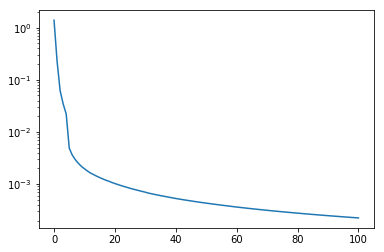

In [15]:
yhat = gslr.predict(X, W_hat)
num_cor = gslr.num_correct(y, yhat)
print('Train accuracy: {}'.format(num_cor / float(len(y))))

plt.plot(losses)
plt.yscale('log')

### iii. Unpack Results

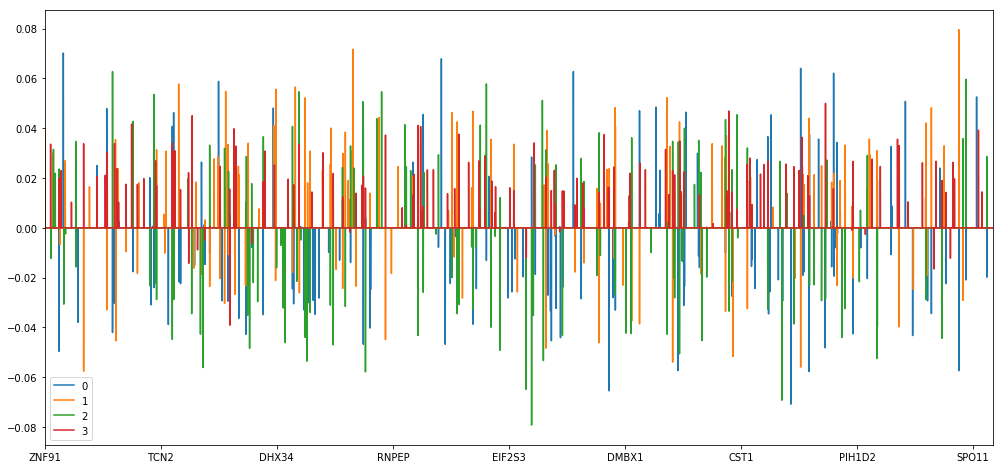

In [16]:
coefs = pd.DataFrame(W_hat, columns=dataset.columns, index=labeler.inverse_transform(list(range(c))))
coefs.transpose().plot(figsize=(17,8))

In [17]:
features = coefs.columns[(coefs != 0).any()].tolist()
len(features)

446

In [18]:
features

['SLC27A2',
 'LHX8',
 'JUP',
 'ICA1L',
 'MICAL1',
 'LRP1',
 'COLEC12',
 'CASK',
 'CARMIL1',
 'MEIS2',
 'NRCAM',
 'NEFM',
 'LDHAL6B',
 'MPP3',
 'CSNK1A1',
 'KRT75',
 'FAM210B',
 'SRC',
 'TAGLN3',
 'MFAP4',
 'SH3GL3',
 'HK2',
 'SST',
 'HLX',
 'PAX3',
 'GNG3',
 'EPHA3',
 'DLG3',
 'CRIP1',
 'CKS1B',
 'GAB2',
 'TIMP2',
 'ELAVL1',
 'SKP2',
 'EMX2',
 'SH3GL2',
 'TGIF1',
 'RAC1',
 'ZAP70',
 'TSPYL5',
 'MEIS1',
 'SLC4A8',
 'MDM2',
 'PDE1A',
 'EPHA5',
 'SLC12A7',
 'TBP',
 'RARA',
 'KALRN',
 'PHACTR3',
 'CRABP2',
 'TPPP3',
 'RALGPS2',
 'MAOA',
 'MMP2',
 'ENC1',
 'ADGRG1',
 'GNG11',
 'STON2',
 'GLI3',
 'GNGT1',
 'CMTM2',
 'KRT7',
 'CES1',
 'NPM1',
 'F3',
 'BCR',
 'GNB1',
 'SIX3',
 'CDKN1B',
 'IMPDH1',
 'OTX1',
 'PTEN',
 'NCK2',
 'PIK3R3',
 'DLG4',
 'GAB1',
 'PLXNB1',
 'BAIAP2',
 'SEMA3A',
 'WBP2',
 'POLR3G',
 'NLGN1',
 'PPP1R17',
 'RND2',
 'AIF1L',
 'SNCA',
 'L1CAM',
 'ZNF641',
 'EPHA7',
 'TMEM2',
 'NOTCH2',
 'ARRB2',
 'LSR',
 'NEK8',
 'KCNA1',
 'MAGEA10',
 'IGF2BP3',
 'CYBRD1',
 'SDC2',
 'BDH2',


In [19]:
coefs.to_pickle('medullo_coefs.pickle')

# ---

In [19]:
coefs = pd.read_pickle('medullo_coefs.pickle')
coefs.index = labeler.inverse_transform(list(range(c)))
coefs.head()

,ZNF91,ACP5,SLC27A2,PAX9,ADAM15,ELOVL2,DDX60L,FGF7,CDHR5,LYPD3,...,CNR2,GIG44,LINC00588,TAAR2,CHRNE,ANKAR,DHH,CYSLTR1,COL23A1,MEDAG
GR3,-0.0,-0.0,-0.000000,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GR4,0.0,-0.0,0.039949,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0
SHH,-0.0,-0.0,-0.000000,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WNT,0.0,0.0,0.000000,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
[coefs.columns[coefs.iloc[k].nonzero()].tolist() for k in range(len(coefs))]

[['COLEC12',
  'NEFM',
  'TAGLN3',
  'HK2',
  'HLX',
  'GNG3',
  'EPHA3',
  'ELAVL1',
  'SH3GL2',
  'TSPYL5',
  'SLC4A8',
  'PDE1A',
  'PHACTR3',
  'CRABP2',
  'RALGPS2',
  'ADGRG1',
  'STON2',
  'F3',
  'IMPDH1',
  'NCK2',
  'DLG4',
  'GAB1',
  'SEMA3A',
  'NLGN1',
  'AIF1L',
  'L1CAM',
  'ARRB2',
  'MAGEA10',
  'CYBRD1',
  'BDH2',
  'SLC38A1',
  'TP53',
  'LYN',
  'GABRA5',
  'NGFR',
  'AKR1C3',
  'BANP',
  'DFNA5',
  'CHN1',
  'WLS',
  'GAP43',
  'TCF4',
  'TSC22D3',
  'AMPH',
  'SCRN1',
  'UBASH3B',
  'APP',
  'CA14',
  'TGFB1',
  'PDE4D',
  'WNT4',
  'DAB1',
  'ENG',
  'GNG2',
  'EFNA1',
  'SLC9A3R1',
  'FSTL5',
  'NMRAL1',
  'FOXS1',
  'ATR',
  'KLHL13',
  'AKR1C1',
  'ROBO2',
  'SFRP1',
  'TP73',
  'NDN',
  'PDGFRA',
  'DCC',
  'GNAI1',
  'BIN1',
  'OTX2',
  'ALDH1A1',
  'YWHAB',
  'GRIA3',
  'PLXNC1',
  'EN1',
  'HDAC1',
  'PAX6',
  'PPP1CA',
  'AKR1C2',
  'NRP1',
  'DCT',
  'EGFR',
  'YAP1',
  'KCNA4',
  'NKX2-2',
  'GRIA4',
  'GRIA2',
  'SOX2',
  'PCK2',
  'CLSTN1',
  'PYCARD